# Import 



In [ ]:
%pip install scikit-learn
%pip install keras

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from keras import optimizers, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed,Dropout, Input
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import Model
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

LABELS = ["Normal", "Anomaly"]

2025-02-09 20:17:22.842496: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 20:17:22.845919: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 20:17:22.856816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739150242.875053 3462191 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739150242.880369 3462191 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 20:17:22.899919: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Import Functions

In [4]:

def temporalize(in_X, lb):
    X = []
    for i in range(lb, len(in_X)+1):
        X.append(in_X[i - lb:i, :])
    X = np.array(X)
    return X


def temporalize_test(in_X, in_y, in_cat, lb):
    X = []
    y = []
    y_cat =[]
    for i in range(lb, len(in_X) + 1):
        X.append(in_X[i - lb:i, :])
        y.append(in_y[i-1])
        y_cat.append(in_cat[i-1])
    X = np.array(X)
    y = np.array(y)
    y_cat = np.array(y_cat)
    return X, y, y_cat

def make_lookback(df_t, lb):
    X = []
    X = np.array(X)
    users = list(df_t.iloc[:, 0].unique())
    flag = 1
    for usr in users:
        udf = df_t[df_t.iloc[:, 0] == usr]
        input_X = udf.loc[:, ].values
        t1 = temporalize(input_X, lb)
        if flag == 1:
            X = t1
            flag = 0
        else:
            if t1.size != 0:
                X = np.concatenate([X, t1])
    return X


def make_lookback_test(df_t, lb):
    X = []
    X = np.array(X)
    Y = []
    Y = np.array(Y)
    users = list(df_t.iloc[:, 0].unique())
    flag = 1
    for usr in users:
        udf = df_t[df_t.iloc[:, 0] == usr]
        y = udf.iloc[:, -1].values
        input_X = udf.iloc[:, :-1].values
        t1, t2 = temporalize_test(input_X, y, lb)
        if flag == 1:
            X = t1
            Y = t2
            flag = 0
        else:
            if t1.size != 0:
                X = np.concatenate([X, t1])
                Y = np.concatenate([Y, t2])
    return X, Y
def flatten_data(X):
    lb = X.shape[1]
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, lb-1, :]
    return flattened_X
def prepare_test_data(traindata, testdata):
    lb = traindata.shape[1]
    y = traindata[:, 0]
    y = list(y.T)
    z = list(y[0])
    l = len(z)
    test_X = np.zeros((len(testdata), lb, traindata.shape[2]))
    flag = 0
    for item in testdata:
        idx = l - 1 - z[::-1].index(item[0])
        test_X[flag, 0:lb-1, ] = traindata[idx, 1:, ]
        test_X[flag, lb-1:, ] = testdata[flag]
        flag += 1
        print(flag)
    return test_X
def read_data(path):
    df1 = pd.read_csv(path)
    df1 = df1.drop(['start_ts','session_duration'], axis=1)
    df1 = df1.fillna(0)
    # df1.insert(loc=1, column='u', value=df1['user'].values)
    df1['role'] = df1['role'].astype('category')
    df1['role'] = df1['role'].cat.codes
    df1['user'] = df1['user'].astype('category')
    df1['user'] = df1['user'].cat.codes

    # df1['u'] = df1['u'].astype('category')
    # df1['u'] = df1['u'].cat.codes
    # ce_ord = ce.BinaryEncoder(cols=['u'])
    # df1 = ce_ord.fit_transform(df1)

    return df1

def arrange_data(array_np):
    X = array_np
    new_array = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    y = X[:, 0]
    y = list(y.T)
    z = list(y[0])
    all_items = np.array(z)
    z = list(dict.fromkeys(z))
    flag = 0
    length = len(X)
    while length != 0:
        ind = []
        for user in z:
            if user in all_items:
                i = all_items.tolist().index(user)
                new_array[flag] = X[i]
                ind.append(i)
                print(flag)
                flag += 1
        X = np.delete(X, ind, axis=0)
        all_items = np.delete(all_items, ind)
        length = len(X)
    return new_array

# Get train, valid and test data

In [5]:
def get_train_valid_test_data(train, valid, test, lb):
    X_train = []
    X_train = np.array(X_train)
    X_valid = []
    X_valid = np.array(X_train)
    X_test = []
    X_test = np.array(X_train)
    y_test = []
    y_test = np.array(y_test)
    
    users = list(train.user.unique())
    flag = 1
    for usr in users:
        u_train = train.loc[train['user'] == usr]
        u_valid = valid.loc[valid['user'] == usr]
        u_test = test.loc[test['user'] == usr]
        u_y_test = u_test['class'].values
        u_test = u_test.drop(['class'], axis=1)
        
        sc = MinMaxScaler(feature_range=(0, 1))
        u_train = sc.fit_transform(u_train)
        u_valid = sc.transform(u_valid)
        u_test = sc.transform(u_test)
        
        t1 = temporalize(u_train, lb)
        t2 = temporalize(u_valid, lb)
        t3, t4 = temporalize_test(u_test, u_y_test, lb)
        
        if flag == 1:
            X_train = t1
            X_valid = t2
            X_test = t3
            y_test = t4
            flag = 0
        else:
            if t1.size != 0:
                X_train = np.concatenate([X_train, t1])
            if t2.size != 0:
                X_valid = np.concatenate([X_valid, t2])
            if t3.size != 0:
                X_test = np.concatenate([X_test, t3])
            if t4.size != 0:
                y_test = np.concatenate([y_test, t4])
    return X_train, X_valid, X_test, y_test


# Get train, test data

In [6]:
def get_train_test_data(train, test, lb):
    X_train = []
    X_train = np.array(X_train)
    X_test = []
    X_test = np.array(X_train)
    y_test = []
    y_test = np.array(y_test)

    y_type = []
    y_type = np.array(y_type)

    users = list(train.user.unique())
    flag = 1
    for usr in users:
        u_train = train.loc[train['user'] == usr]
        u_test = test.loc[test['user'] == usr]
        u_y_test = u_test['class'].values
        u_y_cat = u_test['type'].values
        u_test = u_test.drop(['class','type'], axis=1)
        
        sc = MinMaxScaler(feature_range=(0, 1))
        u_train = sc.fit_transform(u_train)
        u_test = sc.transform(u_test)
        
        t1 = temporalize(u_train, lb)
        t3, t4, t5 = temporalize_test(u_test, u_y_test, u_y_cat, lb)
        
        if flag == 1:
            X_train = t1
            X_test = t3
            y_test = t4
            y_type = t5
            flag = 0
        else:
            if t1.size != 0:
                X_train = np.concatenate([X_train, t1])
            if t3.size != 0:
                X_test = np.concatenate([X_test, t3])
            if t4.size != 0:
                y_test = np.concatenate([y_test, t4])
                y_type = np.concatenate([y_type, t5])
    return X_train, X_test, y_test, y_type

# Import Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Prepare Data

In [7]:
LABELS = ["Normal", "Anomaly"]
train_percent = 242043
test_percent = 0.2
validation_percent = 276388
lookback = 3
df = read_data("/home/sathish/UEBA/data/data.csv")

# # train, test = train_test_split(df, test_size=test_percent, shuffle=False)
train_data = df[0:validation_percent]
#valid_data = df[train_percent:validation_percent]
test_data = df[validation_percent:]

train_data = train_data.drop(['class','type'], axis=1)
# valid_data = valid_data.drop(['class'], axis=1)
X_train, X_test, y_test, y_category = get_train_test_data(train_data, test_data, lookback)
X_train = X_train[:, :, 1:]
X_test = X_test[:, :, 1:]

# Model

In [ ]:
n_features = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
#X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

epochs = 100
batch = 256
lr = 0.0001
timesteps = lookback
encoding_dim = 16
hidden_dim = 8
# Define model
inputs = Input(shape = (timesteps, n_features))
L1 = LSTM(encoding_dim, activation ='relu', return_sequences=True, 
          kernel_regularizer=regularizers.l2(0.00))(inputs)
L2 = LSTM(hidden_dim, activation='relu', return_sequences=False)(L1)
L3 = RepeatVector(timesteps)(L2)
L4 = LSTM(hidden_dim, activation='relu', return_sequences=True)(L3)
L5 = LSTM(encoding_dim, activation='relu', return_sequences=True)(L4)
output = TimeDistributed(Dense(n_features))(L5)
lstm_model = Model(inputs=inputs, outputs=output)
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)


cp = ModelCheckpoint(filepath="ae_classifier.h5",
                     save_best_only=True,
                     verbose=0)

tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 2)
lstm_model_history = lstm_model.fit(X_train, X_train,
                                    epochs=epochs,
                                    batch_size=batch,
                                    shuffle=False,
                                    verbose=1,
                                    validation_split=0.12,
                                    callbacks=[es, cp, tb]).history


plt.plot(lstm_model_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_model_history['val_loss'], linewidth=2, label='Validation')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
print(lstm_model_history['loss'])



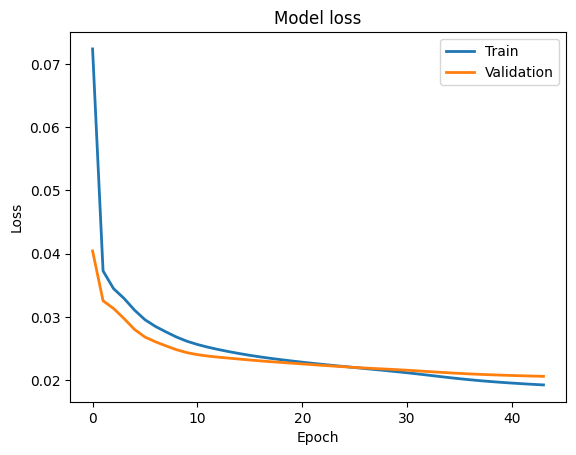

[0.0723530501127243, 0.037258800119161606, 0.034456875175237656, 0.03291242569684982, 0.031061571091413498, 0.02953661046922207, 0.028477143496274948, 0.027616646140813828, 0.026810524985194206, 0.026141073554754257, 0.02562551759183407, 0.025200456380844116, 0.024830898270010948, 0.024497758597135544, 0.024192338809370995, 0.023914016783237457, 0.023661738261580467, 0.023431509733200073, 0.023218909278512, 0.02301940880715847, 0.022829776629805565, 0.022648034617304802, 0.02247289940714836, 0.022304244339466095, 0.0221404992043972, 0.02197984978556633, 0.02182038687169552, 0.02166011929512024, 0.021497322246432304, 0.021329473704099655, 0.0211548563092947, 0.020971613004803658, 0.020779799669981003, 0.020585255697369576, 0.02039511129260063, 0.020215507596731186, 0.02004968374967575, 0.019898999482393265, 0.019762825220823288, 0.019639045000076294, 0.019526129588484764, 0.019422275945544243, 0.019325491040945053, 0.01923551596701145]


In [9]:
plt.plot(lstm_model_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_model_history['val_loss'], linewidth=2, label='Validation')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
print(lstm_model_history['loss'])

# Results

In [10]:
tb.set_model(lstm_model)
test_x_predictions = lstm_model.predict(X_test)

1983/1983 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


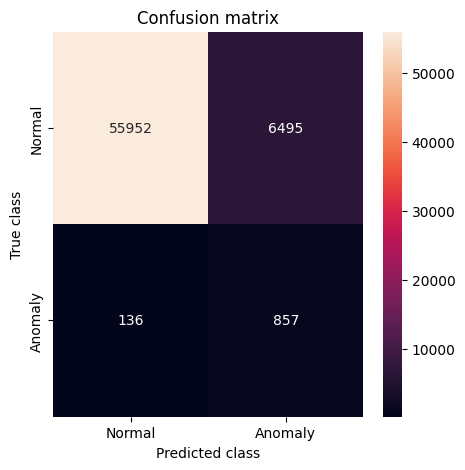

Text(0.5, 0, 'False Positive Rate')

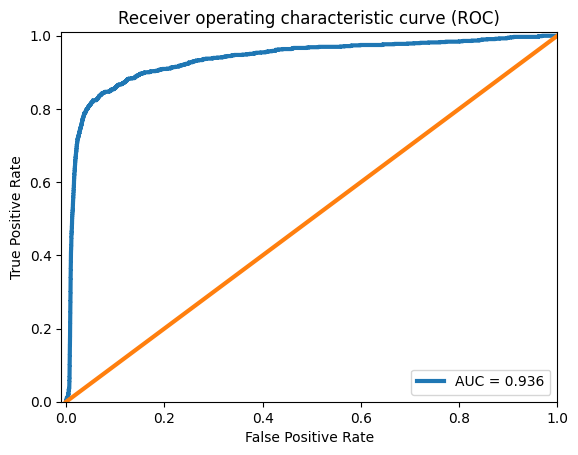

In [11]:
mse = np.mean(np.power(flatten_data(X_test) - flatten_data(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test})

# threshold = error_df.Reconstruction_error.mean()
threshold = 0.04
# output reconstruction error to file
# np.savetxt(out_prediction_file, error_df, delimiter=",")
# Confusion Matrix
pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# #  Plot predicted values
# groups = error_df.groupby('True_class')
# fig, ax = plt.subplots()

# for name, group in groups:
#     ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='')
# ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
# ax.legend()
# plt.title("Reconstruction error for different classes")
# plt.ylabel("Reconstruction error")
# plt.xlabel("Data point index")
# plt.show()

# AUC Plot
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate, )

plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], linewidth=3)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Curve Plots



In [12]:
threshold = 0.02
increment = 0.001
stopping = 0.06
th = []
prec = []
rec = []
accuracy = []
f1 = []
TPR = []
FPR = []
TNR = []
while threshold < stopping:
  pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
  conf_matrix = confusion_matrix(error_df.True_class, pred_y)
  TP = conf_matrix[1][1]
  FP = conf_matrix[0][1]
  TN = conf_matrix[0][0]
  FN = conf_matrix[1][0]
  th.append(threshold)
  p = TP/(TP+FP)
  r = TP/(TP+FN)
  prec.append(p)
  rec.append(r)
  accuracy.append((TN+TP)/(TN+TP+FN+FP))
  TPR.append(TP/(TP+FN))
  FPR.append(FP/(TN+FP))
  TNR.append(TN/(TN+FP))
  f1.append(2*p*r/(p+r))
  threshold = threshold + increment


# Precision vs Recall

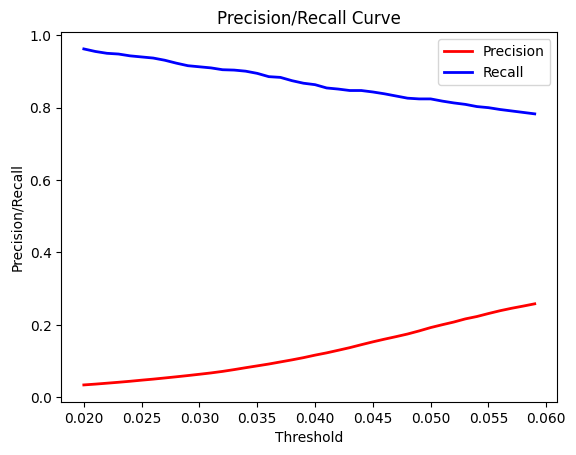

In [13]:
plt.plot(th, prec, linewidth=2, label='Precision', color ='r')
plt.plot(th, rec, linewidth=2, label='Recall', color='b')
plt.title('Precision/Recall Curve')
plt.ylabel('Precision/Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.show()


# **Accuracy Plot**

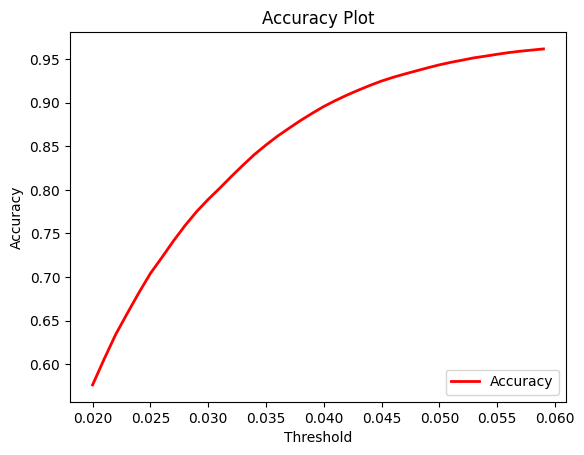

In [14]:
plt.plot(th, accuracy, linewidth=2, label='Accuracy', color ='r')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.legend(loc='lower right')
plt.show()

**F1 Score Plot**

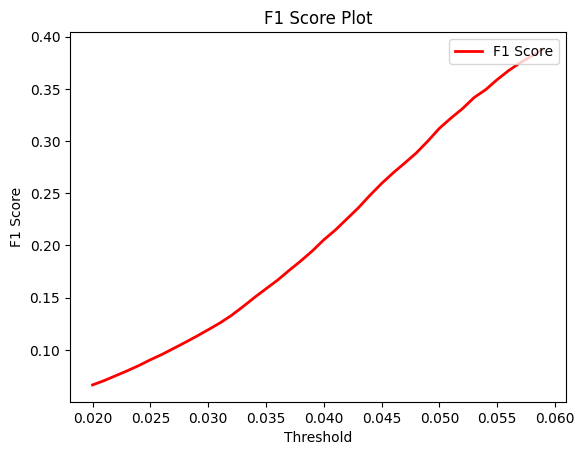

In [15]:
plt.plot(th, f1, linewidth=2, label='F1 Score', color ='r')
plt.title('F1 Score Plot')
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.show()

**TPR vs TNR**

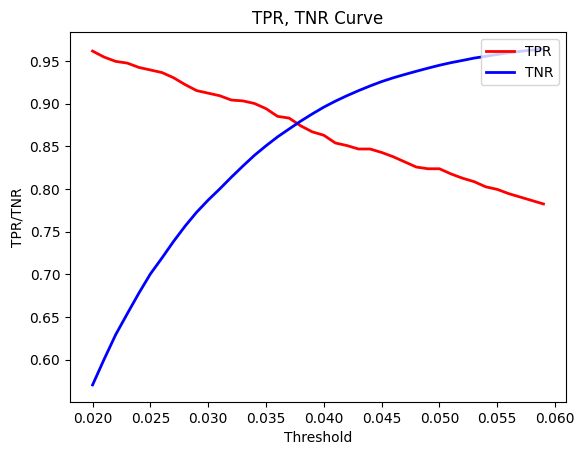

In [16]:
plt.plot(th, TPR, linewidth=2, label='TPR', color ='r')
plt.plot(th, TNR, linewidth=2, label='TNR', color='b')
plt.title('TPR, TNR Curve')
plt.ylabel('TPR/TNR')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.show()